In [1]:
import segmentation_models as sm

2023-02-24 07:58:10.953623: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-02-24 07:58:11.338036: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2023-02-24 07:58:11.338079: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2023-02-24 07:58:11.420836: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-02-24 07:58:14.146576: W tensorflow/stream_executor/platform/de

Segmentation Models: using `keras` framework.


In [11]:
# importing required packages...
import os
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
#import seaborn as sns
from keras.preprocessing.image import ImageDataGenerator
from matplotlib import pyplot as plt
#from patchify import patchify
from PIL import Image
#import segmentation_models as sm
import tensorflow as tf
#from tensorflow.keras.metrics import MeanIoU
from sklearn.preprocessing import MinMaxScaler, StandardScaler
#from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
#from tensorflow.keras.models import load_model
from tqdm import tqdm
from keras.utils import normalize
from tensorflow import keras
from keras.utils import to_categorical
import random
import segmentation_models as sm #pip install segmentation_models
from keras.models import Model, load_model
from keras.layers import Input
from keras.layers.core import Dropout, Lambda
from keras.layers.convolutional import Conv2D, Conv2DTranspose
from keras.layers.pooling import MaxPooling2D
from keras.layers import concatenate
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras import backend as K
from tensorflow.keras import layers
import pickle
from typing import Tuple
#from tensorflow.keras.callbacks import Callback, ModelCheckpoint,  EarlyStopping
#from tensorflow.keras.optimizers import SGD, Adam

In [3]:

keras.backend.set_image_data_format('channels_last')
# or keras.backend.set_image_data_format('channels_first')

In [21]:
def resize_with_pad(image: np.array, 
                    new_shape: Tuple[int, int], 
                    padding_color: Tuple[int] = (0,0,0)) -> np.array:
    """Maintains aspect ratio and resizes with padding.
    Params:
        image: Image to be resized.
        new_shape: Expected (width, height) of new image.
        padding_color: Tuple in BGR of padding color
    Returns:
        image: Resized image with padding
    """
    original_shape = (image.shape[1], image.shape[0])
    ratio = float(max(new_shape))/max(original_shape)
    new_size = tuple([int(x*ratio) for x in original_shape])
    image = cv2.resize(image, new_size)
    delta_w = new_shape[0] - new_size[0]
    delta_h = new_shape[1] - new_size[1]
    top, bottom = delta_h//2, delta_h-(delta_h//2)
    left, right = delta_w//2, delta_w-(delta_w//2)
    image = cv2.copyMakeBorder(image, top, bottom, left, right, cv2.BORDER_CONSTANT, value=padding_color)
    return image

In [22]:

# loading image data...
def image_loader(folder_dir,sx,sy):
    image_dataset = []
    for images in os.listdir(folder_dir):
        path = os.path.join(folder_dir,images)
        image = cv2.imread(path)
        image = resize_with_pad(image, (sx, sy)) #Mantengo la giusta proporzione e aggiungo del padding
        image_dataset.append(image)
    return image_dataset

In [23]:
# loading mask data...
def mask_loader(folder_dir,sx,sy):
    image_dataset = []
    for images in os.listdir(folder_dir):
        path = os.path.join(folder_dir,images)
        image = cv2.imread(path, 0)
        image = resize_with_pad(image, (sx, sy))
        image_dataset.append(image)
    return image_dataset

In [24]:
parent = os.path.abspath(os.path.join(os.getcwd(), os.pardir)) #parent directory
img_folder = os.path.join("..", "car-segmentation", "images")
masks_folder = os.path.join("..", "car-segmentation", "masks")
n_classes = 5 # class for segmentation
size_x = 144
size_y = 144

image_dataset = image_loader(img_folder,size_x,size_y) # real images...
mask_dataset = mask_loader(masks_folder,size_x,size_y) # masked images...
image_dataset = np.array(image_dataset)
mask_dataset = np.array(mask_dataset)
#Espando la dimensione  della maschera
mask_dataset_encoded = np.expand_dims(mask_dataset, axis = 3)

libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known inc

In [25]:
print(image_dataset.shape)
print(mask_dataset_encoded.shape)
print("Image shape: ", image_dataset[0].shape)
print("Mask shape: ", mask_dataset_encoded[0].shape)
print("Max pixel value in image is: ", image_dataset.max()) #255 perchè non è normalizzata
print("Labels in the mask are : ", np.unique(mask_dataset_encoded)) # 0,1,2,3,4

(1688, 144, 144, 3)
(1688, 144, 144, 1)
Image shape:  (144, 144, 3)
Mask shape:  (144, 144, 1)
Max pixel value in image is:  255
Labels in the mask are :  [0 1 2 3 4]


In [9]:

#Normalize images (pixel diventano tra 0 e 1)
#image_dataset = image_dataset /255.

In [26]:
#Split training datafrom sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(image_dataset, mask_dataset_encoded, test_size = 0.2, random_state = 42)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size = 0.2, random_state = 42)
print(f"Dimensione training set: {len(X_train)}\nDimensione val set: {len(X_val)}\nDimensione test set: {len(X_test)}")    

Dimensione training set: 1080
Dimensione val set: 270
Dimensione test set: 338


In [27]:
#Le maschere devono avere il formato dell'ultimo layer del modello (256x256x5)
from keras.utils import to_categorical
train_masks_cat = to_categorical(y_train, num_classes=n_classes)
y_train_cat = train_masks_cat.reshape((y_train.shape[0], y_train.shape[1], y_train.shape[2], n_classes))

test_masks_cat = to_categorical(y_test, num_classes=n_classes)
y_test_cat = test_masks_cat.reshape((y_test.shape[0], y_test.shape[1], y_test.shape[2], n_classes))

val_masks_cat = to_categorical(y_val, num_classes=n_classes)
y_val_cat =val_masks_cat.reshape((y_val.shape[0], y_val.shape[1], y_val.shape[2], n_classes))
print("shape precedente: ", y_train.shape)
print("shape attuale: ", y_train_cat.shape)


shape precedente:  (1080, 144, 144, 1)
shape attuale:  (1080, 144, 144, 5)


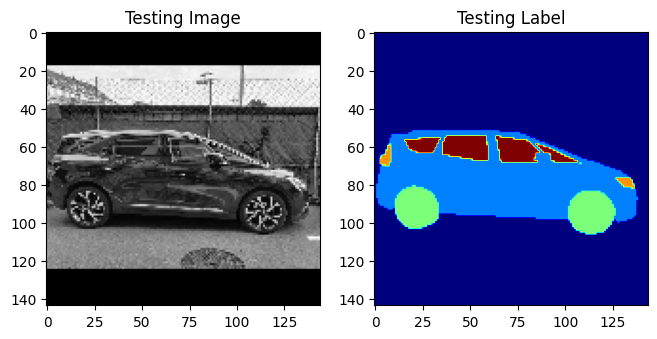

In [28]:
#Sanity check delle immagini
n = random.randint(0, len(X_test)-1)
test_img = X_train[n]
ground_truth=y_train[n]


plt.figure(figsize=(12, 8))
plt.subplot(231)
plt.title('Testing Image')
plt.imshow(test_img[:,:,0], cmap='gray')
plt.subplot(232)
plt.title('Testing Label')
plt.imshow(ground_truth[:,:,0], cmap='jet')

In [29]:
# multiclass segmentation with non overlapping class masks (your classes + background)
# define model
BACKBONE='resnet34'
preprocess_input = sm.get_preprocessing(BACKBONE)
# preprocess input
X_train = preprocess_input(X_train)
X_val = preprocess_input(X_val)
X_test = preprocess_input(X_test)

In [30]:
IMG_HEIGHT = X_train.shape[1]
IMG_WIDTH  = X_train.shape[2]
IMG_CHANNELS = X_train.shape[3]
input_shape = (IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS)
print(input_shape)
print(X_train.shape)
print(X_test.shape)
print(y_train_cat.shape)
print(y_test_cat.shape)

(144, 144, 3)
(1080, 144, 144, 3)
(338, 144, 144, 3)
(1080, 144, 144, 5)
(338, 144, 144, 5)


In [31]:
# define model
model = sm.PSPNet(BACKBONE,input_shape=input_shape, classes=n_classes, activation='softmax', encoder_weights='imagenet', psp_use_batchnorm=True)
metrics = [sm.metrics.iou_score,sm.metrics.FScore(threshold=0.5), 'accuracy']
model.compile('Adam', loss=sm.losses.bce_jaccard_loss, metrics=metrics,)

print(model.summary())

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 data (InputLayer)              [(None, 144, 144, 3  0           []                               
                                )]                                                                
                                                                                                  
 bn_data (BatchNormalization)   (None, 144, 144, 3)  9           ['data[0][0]']                   
                                                                                                  
 zero_padding2d (ZeroPadding2D)  (None, 150, 150, 3)  0          ['bn_data[0][0]']                
                                                                                                  
 conv0 (Conv2D)                 (None, 72, 72, 64)   9408        ['zero_padding2d[0][0]']   

In [17]:
#os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
#model.fit(X_train, y_train_cat, batch_size=2, epochs=10, validation_data=(X_test, y_test_cat))

from keras.callbacks import CSVLogger
#Fase di TRAINING del modello, early stopping con pazienza a 5
csv_logger = CSVLogger('PSP_144x144.log', separator=',', append=False)
callbacks =[keras.callbacks.EarlyStopping(monitor="val_loss", patience=9)]
percorso = os.path.join("..",'PSP_144x144.hdf5')
m_save = ModelCheckpoint(percorso, save_best_only=True, monitor='val_loss', mode='min')

history = model.fit(X_train, y_train_cat, 
                    batch_size = 16, 
                    verbose=1, 
                    epochs=80, 
                    validation_data=(X_val, y_val_cat), 
                    callbacks=[callbacks,csv_logger, m_save],
                    shuffle=True)

2023-02-24 08:01:01.792358: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 67184640 exceeds 10% of free system memory.
2023-02-24 08:01:01.873236: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 447897600 exceeds 10% of free system memory.


Epoch 1/80


2023-02-24 08:01:08.578941: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 21233664 exceeds 10% of free system memory.
2023-02-24 08:01:08.669080: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 21233664 exceeds 10% of free system memory.
2023-02-24 08:01:08.703462: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 22429696 exceeds 10% of free system memory.


68/68 [==============================] - 158s 2s/step - loss: 0.5391 - iou_score: 0.5479 - f1-score: 0.6483 - accuracy: 0.9203 - val_loss: 0.5074 - val_iou_score: 0.5683 - val_f1-score: 0.6872 - val_accuracy: 0.9347
Epoch 2/80
68/68 [==============================] - 150s 2s/step - loss: 0.3744 - iou_score: 0.6723 - f1-score: 0.7732 - accuracy: 0.9603 - val_loss: 0.4370 - val_iou_score: 0.6203 - val_f1-score: 0.7086 - val_accuracy: 0.9455
Epoch 3/80
68/68 [==============================] - 150s 2s/step - loss: 0.3328 - iou_score: 0.7085 - f1-score: 0.8080 - accuracy: 0.9666 - val_loss: 0.4465 - val_iou_score: 0.6204 - val_f1-score: 0.7273 - val_accuracy: 0.9400
Epoch 4/80
68/68 [==============================] - 151s 2s/step - loss: 0.3053 - iou_score: 0.7327 - f1-score: 0.8303 - accuracy: 0.9700 - val_loss: 0.3535 - val_iou_score: 0.6923 - val_f1-score: 0.7962 - val_accuracy: 0.9600
Epoch 5/80
68/68 [==============================] - 154s 2s/step - loss: 0.2864 - iou_score: 0.7492 - f

: 

: 

In [33]:
from keras.models import load_model
from keras.callbacks import CSVLogger
#Fase di TRAINING del modello, early stopping con pazienza a 3
csv_logger = CSVLogger('PSP_144x144_p2.log', separator=',', append=False)
callbacks =[keras.callbacks.EarlyStopping(monitor="val_loss", patience=3)]
path = os.path.join("..",'PSP_144x144.hdf5')
path2 = os.path.join("..", "PSP_144x144_p2.hdf5")
m_save = ModelCheckpoint(path2, save_best_only=True, monitor='val_loss', mode='min')

loss = sm.losses.bce_jaccard_loss
new_model = load_model(path,custom_objects={'binary_crossentropy_plus_jaccard_loss': loss,'iou_score': sm.metrics.iou_score, 'f1-score':sm.metrics.FScore(threshold=0.5)}) 


history = new_model.fit(X_train, y_train_cat, 
                    batch_size = 16, 
                    verbose=1, 
                    epochs=20, 
                    validation_data=(X_val, y_val_cat), 
                    callbacks=[callbacks,csv_logger, m_save],
                    shuffle=True)

Epoch 1/20


2023-02-24 11:20:58.249611: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 447897600 exceeds 10% of free system memory.


68/68 [==============================] - ETA: 0s - loss: 0.1562 - iou_score: 0.8676 - f1-score: 0.9288 - accuracy: 0.9882

2023-02-24 11:23:33.158536: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 111974400 exceeds 10% of free system memory.


68/68 [==============================] - 164s 2s/step - loss: 0.1562 - iou_score: 0.8676 - f1-score: 0.9288 - accuracy: 0.9882 - val_loss: 0.2298 - val_iou_score: 0.8093 - val_f1-score: 0.8870 - val_accuracy: 0.9794
Epoch 2/20
68/68 [==============================] - 156s 2s/step - loss: 0.1563 - iou_score: 0.8676 - f1-score: 0.9288 - accuracy: 0.9881 - val_loss: 0.2312 - val_iou_score: 0.8090 - val_f1-score: 0.8871 - val_accuracy: 0.9792
Epoch 3/20
68/68 [==============================] - 157s 2s/step - loss: 0.1556 - iou_score: 0.8683 - f1-score: 0.9295 - accuracy: 0.9882 - val_loss: 0.2311 - val_iou_score: 0.8094 - val_f1-score: 0.8879 - val_accuracy: 0.9786
Epoch 4/20
68/68 [==============================] - 156s 2s/step - loss: 0.1555 - iou_score: 0.8684 - f1-score: 0.9294 - accuracy: 0.9883 - val_loss: 0.2299 - val_iou_score: 0.8105 - val_f1-score: 0.8886 - val_accuracy: 0.9794


: 